<a href="https://colab.research.google.com/github/11doris/jazz-maestro/blob/colab_word_embeddings/model_01_lsi_sections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sections as Input

In [ ]:
pip install wandb

     |████████████████████████████████| 1.7 MB 5.0 MB/s 
     |████████████████████████████████| 180 kB 3.8 MB/s 
     |████████████████████████████████| 97 kB 4.4 MB/s 
     |████████████████████████████████| 140 kB 31.9 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=24efa2794f453b43b250618e632e2b4fa739fac32a7f759a0caf55f7d2051d22
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=132550923cee528cb2de493f69e06eaa96189b095a858a30456231d2cccd30b4
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


In [ ]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import wandb

In [ ]:
!pip uninstall gensim -y

Found existing installation: gensim 3.6.0
Uninstalling gensim-3.6.0:
  Successfully uninstalled gensim-3.6.0


In [ ]:
!pip install gensim

     |████████████████████████████████| 24.1 MB 2.2 MB/s 


In [ ]:
import gensim
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pprint
import pandas as pd
import numpy as np
from collections import Counter
import plotly.express as px
from tqdm import tqdm 
from gensim.models.doc2vec import Doc2Vec
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.lsimodel import LsiModel
from gensim.models import CoherenceModel
from gensim import corpora
from gensim import similarities
import pickle
import os
import zipfile


In [ ]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
print(gensim.__version__)

4.1.2


In [ ]:
!rm data.csv

rm: cannot remove 'data.csv': No such file or directory


In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Configuration


In [ ]:
use_wandb = True

In [ ]:
generate_webapp_data = True

In [ ]:
docu = 'sections'
#docu = 'tunes'
chords_preprocessing = 'rootAndDegreesPlus'

In [ ]:
ngrams_for_input = [2]

In [ ]:
phrases_threshold = 1.0  # 1.0 for no phrases

In [ ]:
remove_repetitions = False

In [ ]:
input_files = {
    'sections': {
        # M7 and 6 reduced to major triad, m7 reduced to m, dominant 7, m7b5, diminished, and all (b5) left as they are.
        'rootAndDegreesPlus': '1NP6trpfnEPnFqJbmcuClvkBB28PNdF8c',
        'rootAndDegrees7': '',
        'rootAndDegreesSimplified': '1vyC9voFf2vpcKmS5kZBJ9Rafm7wuuzD8',
    },
    'tunes': {
        'rootAndDegreesPlus': '',
        'rootAndDegrees7': '',
        'rootAndDegreesSimplified': '',
    }
}

In [ ]:
tunes_eval_list = [
  "Sweet Sue, Just You [jazz1350]",
  "On The Sunny Side Of The Street [jazz1350]",
  "These Foolish Things [jazz1350]", 
  "Blue Moon [jazz1350]",
  "I Got Rhythm [jazz1350]",
  "Old Fashioned Love [trad]",
  "Exactly Like You [jazz1350]",
  "Honeysuckle Rose [jazz1350]",
  "Misty [jazz1350]",
  "Wow [jazz1350]",
  "Take The A Train [jazz1350]"
]

tunes_eval_list = sorted(tunes_eval_list)
tunes_eval_list

['Blue Moon [jazz1350]',
 'Exactly Like You [jazz1350]',
 'Honeysuckle Rose [jazz1350]',
 'I Got Rhythm [jazz1350]',
 'Misty [jazz1350]',
 'Old Fashioned Love [trad]',
 'On The Sunny Side Of The Street [jazz1350]',
 'Sweet Sue, Just You [jazz1350]',
 'Take The A Train [jazz1350]',
 'These Foolish Things [jazz1350]',
 'Wow [jazz1350]']

In [ ]:
contrafacts = [
               ("26-2 [jazz1350]", "Confirmation [jazz1350]"),
               ("52nd Street Theme [jazz1350]", "I Got Rhythm [jazz1350]"), # not a good match
               ("Ablution [jazz1350]", "All The Things You Are [jazz1350]"),
               ("Anthropology [jazz1350]", "I Got Rhythm [jazz1350]"),
               ("Ballade [jazz1350]", "As Long As I Live [jazz1350]"),  # A from Ballade with B from As Long As I
               ("Bright Mississippi [jazz1350]", "Sweet Georgia Brown [jazz1350]"),
               ("C.T.A. [jazz1350]", "I Got Rhythm [jazz1350]"),
               #( "Celia [jazz1350]", "I Got Rhythm [jazz1350]"),
               ("Cottontail [jazz1350]", "I Got Rhythm [jazz1350]"),
               ("Countdown [jazz1350]", "Tune Up [jazz1350]"),
               ("Dewey Square [jazz1350]", "Oh, Lady Be Good [jazz1350]"),
               ("Dexterity [jazz1350]", "I Got Rhythm [jazz1350]"),
               ("Dig [jazz1350]", "Sweet Georgia Brown [jazz1350]"),
               ("Donna Lee [jazz1350]", "Indiana (Back Home Again In) [jazz1350]"),
               ("Don't Be That Way [jazz1350]", "I Got Rhythm [jazz1350]"),  # cannot be found; bridge in different key
               #("Eternal Triangle [jazz1350]", "I Got Rhythm [jazz1350]"),
               ("Evidence [jazz1350]", "Just You, Just Me [jazz1350]"),
               ("Flintstones [jazz1350]", "I Got Rhythm [jazz1350]"),
               ("Four On Six [jazz1350]", "Summertime [jazz1350]"),
               ("Freight Train [jazz1350]", "Blues For Alice [jazz1350]"),
               ("Good Bait [jazz1350]", "I Got Rhythm [jazz1350]"),  # A sections
               ("Hackensack [jazz1350]", "Oh, Lady Be Good [jazz1350]"),
               ("Half Nelson [jazz1350]", "Lady Bird [jazz1350]"),
               ("Hot House [jazz1350]", "What Is This Thing Called Love [jazz1350]"),
               ("Impressions [jazz1350]", "So What [jazz1350]"),
               ("In A Mellow Tone (In A Mellotone) [jazz1350]", "Rose Room [jazz1350]"),
               ("In Walked Bud [jazz1350]", "Blue Skies [jazz1350]"),
               ("Ko Ko [jazz1350]", "Cherokee [jazz1350]"),
               ("Lennie's Pennies [jazz1350]", "Pennies From Heaven [jazz1350]"),   ## Lennie's Pennies is in minor and therefore transposed to Amin... not possible to recognize like that
               #( "Let's Call This [jazz1350]", "Honeysuckle Rose [jazz1350]"),
               ("Little Rootie Tootie [jazz1350]", "I Got Rhythm [jazz1350]"),
               ("Little Willie Leaps [jazz1350]", "All God's Chillun Got Rhythm [jazz1350]"),
               ("Lullaby Of Birdland [jazz1350]", "Love Me Or Leave Me [jazz1350]"),
               #("Moose The Mooche [jazz1350]", "I Got Rhythm [jazz1350]"),
               ("My Little Suede Shoes [jazz1350]", "Jeepers Creepers [jazz1350]"),
               #("Oleo [jazz1350]", "I Got Rhythm [jazz1350]"),
               ("Ornithology [jazz1350]", "How High The Moon [jazz1350]"),
               #("Passport [jazz1350]", "I Got Rhythm [jazz1350]"),
               ("Quasimodo (Theme) [jazz1350]", "Embraceable You [jazz1350]"),
               #("Rhythm-a-ning [jazz1350]", "I Got Rhythm [jazz1350]"),
               ("Room 608 [jazz1350]", "I Got Rhythm [jazz1350]"),
               #("Salt Peanuts [jazz1350]", "I Got Rhythm [jazz1350]"),
               ("Satellite [jazz1350]", "How High The Moon [jazz1350]"),
               ("Scrapple From The Apple [jazz1350]", "Honeysuckle Rose [jazz1350]"), # A section
               ("Scrapple From The Apple [jazz1350]", "I Got Rhythm [jazz1350]"), # B section
               #("Segment [jazz1350]", "I Got Rhythm [jazz1350]"),
               #("Seven Come Eleven [jazz1350]", "I Got Rhythm [jazz1350]"),
               #("Shaw 'Nuff [jazz1350]", "I Got Rhythm [jazz1350]"),
               #("Theme, The [jazz1350]", "I Got Rhythm [jazz1350]"),
               ("Tour De Force [jazz1350]", "Jeepers Creepers [jazz1350]"),
               ("Wow [jazz1350]", "You Can Depend On Me [jazz1350]"),
               ("Yardbird Suite [jazz1350]", "Rosetta [jazz1350]"),

               # following tunes are not from wikipedia),
               ("Sweet Sue, Just You [jazz1350]", "Honeysuckle Rose [jazz1350]"),  # A section
               #("All Of Me [jazz1350]", "Pennies From Heaven [jazz1350]"), # bars 25-28 of All of Me are same as bars 17-20 of Pennies From Heaven, but different key!
               ("Sweet Sue, Just You [jazz1350]", "Bye Bye Blackbird [jazz1350]"), # Bridge same
               ("These Foolish Things [jazz1350]", "Blue Moon [jazz1350]"), # first 8 bars same
               ("These Foolish Things [jazz1350]", "More Than You Know [jazz1350]"),
               ("These Foolish Things [jazz1350]", "Isn't It A Pity [jazz1350]"),
               ("These Foolish Things [jazz1350]", "Soultrane [jazz1350]"),
               ("These Foolish Things [jazz1350]", "Why Do I Love You [jazz1350]"),
               ("Misty [jazz1350]", "Portrait Of Jennie [jazz1350]"),
               ("Misty [jazz1350]", "September In The Rain [jazz1350]"),
               ("Misty [jazz1350]", "I May Be Wrong [jazz1350]"),  

               # identical tunes
               ("Five Foot Two [trad]", "Please Don't Talk About Me When I'm Gone [trad]"),
               ("What Is This Thing Called Love [jazz1350]", "Subconscious Lee [jazz1350]"),
               ("Sweet Georgia Brown [jazz1350]", "Dig [jazz1350]"),


               # almost identical tunes
               ("What Is This Thing Called Love [jazz1350]", "Hot House [jazz1350]"),
               ("Jeannie's Song [jazz1350]", "Shiny Stockings [jazz1350]"),
               ("Alone Together [jazz1350]", "Segment [jazz1350]"),
               ("Baubles, Bangles and Beads [jazz1350]", "Bossa Antigua [jazz1350]"),
               ("There Will Never Be Another You [jazz1350]", "A Weaver Of Dreams [jazz1350]"),
               ("Moten Swing [jazz1350]", "Once In A While (Ballad) [trad]"), # same bridge, similar A
               ("All I Do Is Dream Of You [trad]", "L-O-V-E [jazz1350]"),


               # same A section
               ("Nancy (With The Laughing Face) [jazz1350]", "Body And Soul [jazz1350]"),
               ("Exactly Like You [jazz1350]", "True (You Don't Love Me ) [trad]"),
               ("Exactly Like You [jazz1350]", "Jersey Bounce [trad]"),
               ("Take The A Train [jazz1350]", "Girl From Ipanema, The [jazz1350]"),
               ("My Heart Stood Still [jazz1350]", "All Too Soon [jazz1350]"),
               ("Undecided [jazz1350]", "Broadway [jazz1350]"),
               ("Let's Fall In Love [jazz1350]", "Heart And Soul [jazz1350]"),
               ("Come Back To Me [jazz1350]", "I Wish I Knew [jazz1350]"),
               ("Wait Till You See Her [jazz1350]", "A Certain Smile [jazz1350]"),
               ("Killer Joe [jazz1350]", "Straight Life [jazz1350]"),
               ("Softly, As In A Morning Sunrise [jazz1350]", "Segment [jazz1350]"),
               ("Bei Mir Bist Du Schon (Root Hog Or Die) [trad]", "Egyptian Fantasy [trad]"),
               ("Bei Mir Bist Du Schon (Root Hog Or Die) [trad]", "Puttin' On The Ritz [jazz1350]"),
               ("Coquette [trad]", "Pretend You're Happy When You're Blue [trad]"),
               ("Softly, As In A Morning Sunrise [jazz1350]", "Strode Rode [jazz1350]"),
               ("Glory Of Love, The [jazz1350]", "I've Got My Fingers Crossed [trad]"),
               ("Charleston, The [jazz1350]", "As Long As I Live [jazz13350]"),
               ("Fine And Dandy [jazz1350", "I Can't Give You Anything But Love [jazz1350]"),
               ("I'll Close My Eyes [jazz1350]", "Bluesette [jazz1350]"),
               ("I'll Close My Eyes [jazz1350]", "There Will Never Be Another You [jazz1350]"),



               # same bridge
               ("If I Had You [jazz1350]", "Too Young To Go Steady [jazz1350]"),
               ("Undecided [jazz1350]", "Satin Doll [jazz1350]"),
               ("Billy Boy [jazz1350]", "Elora [jazz1350]"),
               ("Dearly Beloved [jazz1350]", "We See [jazz1350]"),
               ("Alone Together [jazz1350]", "A Night In Tunisia [jazz1350]"),
               ("A Night In Tunisia [jazz1350]", "Segment [jazz1350]"),
               ("Oh! Lady Be Good [trad]", "Sentimental Journey [jazz1350]"),
               ("You Can Depend On Me [jazz1350]", "Move [jazz1350]"),
               ("I Want To Be Happy [jazz1350]", "A Beautiful Friendship [jazz1350]"),
               ("Flying Home [jazz1350]", "Down For Double [jazz1350]"),
               ("Cheek To Cheek [jazz1350]", "Violets For Your Furs [jazz1350]"),
               ("Let's Fall In Love [jazz1350]", "At Last [jazz1350]"),
               ("Don't Be That Way [jazz1350]", "Long Ago And Far Away [jazz1350]"),
               ("On The Sunny Side Of The Street [jazz1350]", "I'm Confessin' That I Love You [jazz1350]"),
               ("On The Sunny Side Of The Street [jazz1350]", "Eclypso [jazz1350]"),
               ("On The Sunny Side Of The Street [jazz1350]", "You Stepped Out Of A Dream [jazz1350]"),
               ("A Beautiful Friendship [jazz1350", "I Want To Be Happy [jazz1350"),
               ("Satin Doll [jazz1350]", "Undecided [jazz1350]"),
               

               

               # similar A section
               ("I Like The Likes Of You [jazz1350]", "Mountain Greenery [jazz1350]"),
               ("My Secret Love [jazz1350]", "Samba De Orfeu [jazz1350]"),
               ("Let's Call The Whole Thing Off [jazz1350]", "Fine And Dandy [jazz1350]"),


               # similar B section
               ("Folks Who Live On The Hill, The [jazz1350]", "My One And Only Love [jazz1350]"),
               ("As Long As I Live [jazz1350]", "I'm Glad There Is You [jazz1350]"),
               ("I May Be Wrong [jazz1350]", "Teach Me Tonight [jazz1350]"),
               ("Am I Blue [jazz1350]", "Come Back To Me [jazz1350]"),
               ("My One And Only Love [jazz1350]", "Am I Blue [jazz1350]"),
               ("On The Sunny Side Of The Street [jazz1350]", "September In The Rain [jazz1350]"),
               ("On The Sunny Side Of The Street [jazz1350]", "Mountain Greenery [jazz1350]"),
               ("On The Sunny Side Of The Street [jazz1350]", "There's No You [jazz1350]"),
               ("These Foolish Things [jazz1350]", "Embraceable You [jazz1350]"),
               ("These Foolish Things [jazz1350]", "Rosetta [jazz1350]"),

               # same C section
               ("Bill Bailey [jazz1350]", "Bourbon Street Parade [jazz1350]"),

               # Stella C is like Woody B
               ("Woody'n You [jazz1350]", "Stella By Starlight [jazz1350]"),

               # similar vocabulary, different progressions
               ("Tangerine [jazz1350]", "Tea For Two [jazz1350]"),
               ("I Can't Give You Anything But Love [jazz1350]", "You Can Depend On Me [jazz1350]"),
               ("This Year's Kisses [jazz1350]", "My Monday Date [trad]"),
               ("A Blossom Fell [jazz1350]", "Among My Souvenirs [jazz1350]"),

]

In [ ]:
len(contrafacts)

111

# Initialization

## Download the Data

In [ ]:
input_data = input_files[docu][chords_preprocessing]

input_path = f"https://docs.google.com/uc?export=download&id={input_data}"
data_file_name = 'data.csv'


In [ ]:
input_path

'https://docs.google.com/uc?export=download&id=1NP6trpfnEPnFqJbmcuClvkBB28PNdF8c'

In [ ]:
!wget --no-check-certificate "$input_path" -O "$data_file_name"

--2021-12-20 13:11:23--  https://docs.google.com/uc?export=download&id=1NP6trpfnEPnFqJbmcuClvkBB28PNdF8c
Resolving docs.google.com (docs.google.com)... 142.250.152.139, 142.250.152.113, 142.250.152.138, ...
Connecting to docs.google.com (docs.google.com)|142.250.152.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/o08orc8do9aprn2sjo95390p1e2uh6k2/1640005875000/14329102864480165501/*/1NP6trpfnEPnFqJbmcuClvkBB28PNdF8c?e=download [following]
--2021-12-20 13:11:24--  https://doc-0g-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/o08orc8do9aprn2sjo95390p1e2uh6k2/1640005875000/14329102864480165501/*/1NP6trpfnEPnFqJbmcuClvkBB28PNdF8c?e=download
Resolving doc-0g-4c-docs.googleusercontent.com (doc-0g-4c-docs.googleusercontent.com)... 74.125.69.132, 2607:f8b0:4001:c08::84
Connecting to doc-0g-4c-docs.googleusercontent.com (doc-0g-4

### Read Chords Input Data

In [ ]:
df = pd.read_csv(data_file_name, sep='\t', index_col="id")
df = df.reset_index()
df.head(5)

,id,file_name,title,title_playlist,tune_mode,tune_id,section_name,section_id,chords
0,0,dataset/jazz1350/26-2.xml,26-2,26-2 [jazz1350],major,0,A,1,C Eb7 G# B7 E G7 Gm C7 F G#7 C# E7 Am D7 Dm G7
1,1,dataset/jazz1350/26-2.xml,26-2,26-2 [jazz1350],major,0,A,2,C Eb7 G# B7 E G7 Gm C7 F Eb7 G# B7 E G7 C
2,2,dataset/jazz1350/26-2.xml,26-2,26-2 [jazz1350],major,0,B,3,Gm C7 Bm E7 A C7 F Bbm Eb7 G# Dm G7
3,3,dataset/jazz1350/26-2.xml,26-2,26-2 [jazz1350],major,0,A,4,C Eb7 G# B7 E G7 Gm C7 F Eb7 G# B7 E G7 C
4,4,dataset/jazz1350/500 Miles High.xml,500 Miles High,500 Miles High [jazz1350],minor,1,A,1,Am Am Cm Cm Eb Eb Em7b5 A7 Dm Dm Bm7b5 Bm7b5 B...


### Meta Data

In [ ]:
titles = df.loc[:, ['id', 'tune_id', 'section_id', 'section_name', 'title', 'title_playlist', 'tune_mode']]
titles[:5]

,id,tune_id,section_id,section_name,title,title_playlist,tune_mode
0,0,0,1,A,26-2,26-2 [jazz1350],major
1,1,0,2,A,26-2,26-2 [jazz1350],major
2,2,0,3,B,26-2,26-2 [jazz1350],major
3,3,0,4,A,26-2,26-2 [jazz1350],major
4,4,1,1,A,500 Miles High,500 Miles High [jazz1350],minor


In [ ]:
titles_dict = titles.to_dict()

sectionid_to_title = titles_dict['title_playlist']
sectionid_to_titleid = titles_dict['tune_id']


In [ ]:
tunes = df.loc[:, ['tune_id', 'title_playlist']].drop_duplicates()
tunes = tunes.set_index('tune_id').to_dict()
titleid_to_title = tunes['title_playlist']

In [ ]:
len(titleid_to_title)

1686

In [ ]:
title_to_titleid = {v: k for k, v in titleid_to_title.items()}


In [ ]:
titles_rows = titles.to_dict(orient='records')
sectionid_to_section = []
for i, row in enumerate(titles_rows):
  name = f"{row['title']}, section{row['section_id']} ({row['section_name']})"
  sectionid_to_section.append(name)
  

In [ ]:
sectionid_to_sectionlabel = []
for i, row in enumerate(titles_rows):
  sectionid_to_sectionlabel.append(row['section_name'])
  

In [ ]:
title_to_sectionid = {}

for row in titles.iterrows():
  title = row[1]['title_playlist']
  if title not in title_to_sectionid:
    title_to_sectionid[title] = [row[1]['id']]
  else:
    title_to_sectionid[title].append(row[1]['id'])

### Create Directories on Colab

In [ ]:
!rm -R output
!mkdir output

rm: cannot remove 'output': No such file or directory


## Initialization for wandb variables

In [ ]:
recommender_results_cols = ['reference', 'id', 'method', 'similar', 'score_div_max', 'score']
recommender_results = pd.DataFrame(columns=recommender_results_cols)

In [ ]:
lsi_config = {
    'num_topics': 100, #22, # 100 gives a better value for the contrafacts test
}

In [ ]:
doc2vec_config = {
    'general': {
        'chords_preprocessing': chords_preprocessing,
        'tag_sections_and_tunes': False,
    },
    'model': {
        'dm': 1,
        'vector_size': 100,
        'window': 2,
        'epochs': 40,
        #'workers': 1,
        'min_count': 1,
        'negative': 10,
        'sample': 0.001,
        'seed': 42
    }
}

In [ ]:
if use_wandb:
  wandb.init(
        # Set entity to specify your username or team name
        # ex: entity="carey",
        # Set the project where this run will be logged
        project="jazztunes", 
        
        # Track hyperparameters and run metadata
        config={
            "input_data": input_path,
            "ngrams_input": ngrams_for_input,
            "comparison": docu,
            "lsi": lsi_config,
            "doc2vec": doc2vec_config,
            "remove_repeated_chords": remove_repetitions,
            "phrases_threshold": phrases_threshold,
            "comment": "sus and sus7 chords added."
        }
    )

wandb: Currently logged in as: doris (use `wandb login --relogin` to force relogin)


In [ ]:
if use_wandb:
  artifact = wandb.Artifact('input_data', type='dataset')
  artifact.add_file('data.csv')
  wandb.log_artifact(artifact)

## Helpers functions

In [ ]:
def ngrams(tokens, n=2, sep='-'):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])]

In [ ]:
def raw_chords_to_df(tunes):
  tunes_chords = [item for tune in tunes for item in tune]
  counts = Counter(tunes_chords)
  df = pd.DataFrame(counts.items(),
                    columns=['chord', 'count']).sort_values(by='count', ascending=False)

  return df

# Data Preparation

In [ ]:
def remove_chord_repetitions(chords):
  previous = ''
  chords_norep = []
  for c in chords:
    if c != previous:
      chords_norep.append(c)
      previous = c
  return chords_norep
  

In [ ]:
lines = df.loc[:, 'chords'].tolist()
data = [line.split(' ') for line in lines]

In [ ]:
processed_corpus = []
for line in data:
  tune_n = []
  if remove_repetitions:
    line = remove_chord_repetitions(line)
  for n in ngrams_for_input:
    tune_n.extend(ngrams(line, n=n))
  processed_corpus.append(tune_n)

for line in processed_corpus[:10]:
  print(line)

['C-Eb7', 'Eb7-G#', 'G#-B7', 'B7-E', 'E-G7', 'G7-Gm', 'Gm-C7', 'C7-F', 'F-G#7', 'G#7-C#', 'C#-E7', 'E7-Am', 'Am-D7', 'D7-Dm', 'Dm-G7']
['C-Eb7', 'Eb7-G#', 'G#-B7', 'B7-E', 'E-G7', 'G7-Gm', 'Gm-C7', 'C7-F', 'F-Eb7', 'Eb7-G#', 'G#-B7', 'B7-E', 'E-G7', 'G7-C']
['Gm-C7', 'C7-Bm', 'Bm-E7', 'E7-A', 'A-C7', 'C7-F', 'F-Bbm', 'Bbm-Eb7', 'Eb7-G#', 'G#-Dm', 'Dm-G7']
['C-Eb7', 'Eb7-G#', 'G#-B7', 'B7-E', 'E-G7', 'G7-Gm', 'Gm-C7', 'C7-F', 'F-Eb7', 'Eb7-G#', 'G#-B7', 'B7-E', 'E-G7', 'G7-C']
['Am-Am', 'Am-Cm', 'Cm-Cm', 'Cm-Eb', 'Eb-Eb', 'Eb-Em7b5', 'Em7b5-A7', 'A7-Dm', 'Dm-Dm', 'Dm-Bm7b5', 'Bm7b5-Bm7b5', 'Bm7b5-Bbm', 'Bbm-Bbm', 'Bbm-Fm', 'Fm-Fm', 'Fm-E7', 'E7-E7', 'E7-Fm', 'Fm-Fm', 'Fm-C#', 'C#-C#', 'C#-Fm', 'Fm-Fm', 'Fm-C#', 'C#-C#']
['Am-C#', 'C#-Bm7b5', 'Bm7b5-E7', 'E7-Am', 'Am-C#', 'C#-Bm7b5', 'Bm7b5-E7', 'E7-Cm', 'Cm-F7', 'F7-Bb', 'Bb-G#m', 'G#m-C#7', 'C#7-F#m7b5', 'F#m7b5-B7', 'B7-E', 'E-E', 'E-E7']
['Am-C#', 'C#-Bm7b5', 'Bm7b5-E7', 'E7-Am', 'Am-C#', 'C#-Bm7b5', 'Bm7b5-E7', 'E7-Cm', 'Cm-F7', 'F7

In [ ]:
len(processed_corpus)

5536

#### Use Phrases

In [ ]:
def make_bigrams(texts, thres=0.2):
  bigram = gensim.models.Phrases(texts, min_count=1, threshold=thres, connector_words=[], scoring='npmi')
  bigram_mod = gensim.models.phrases.Phraser(bigram)
  return [bigram_mod[doc] for doc in texts]


processed_corpus = make_bigrams(data, thres=phrases_threshold)

for i in processed_corpus[:10]:
  print(i)

2021-12-20 13:11:35,532 : INFO : collecting all words and their counts
2021-12-20 13:11:35,538 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2021-12-20 13:11:35,990 : INFO : collected 2112 token types (unigram + bigrams) from a corpus of 76721 words and 5536 sentences
2021-12-20 13:11:35,996 : INFO : merged Phrases<2112 vocab, min_count=1, threshold=1.0, max_vocab_size=40000000>
2021-12-20 13:11:36,003 : INFO : Phrases lifecycle event {'msg': 'built Phrases<2112 vocab, min_count=1, threshold=1.0, max_vocab_size=40000000> in 0.47s', 'datetime': '2021-12-20T13:11:36.003056', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'created'}
2021-12-20 13:11:36,005 : INFO : exporting phrases from Phrases<2112 vocab, min_count=1, threshold=1.0, max_vocab_size=40000000>
2021-12-20 13:11:36,033 : INFO : FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<0 ph

['C', 'Eb7', 'G#', 'B7', 'E', 'G7', 'Gm', 'C7', 'F', 'G#7', 'C#', 'E7', 'Am', 'D7', 'Dm', 'G7']
['C', 'Eb7', 'G#', 'B7', 'E', 'G7', 'Gm', 'C7', 'F', 'Eb7', 'G#', 'B7', 'E', 'G7', 'C']
['Gm', 'C7', 'Bm', 'E7', 'A', 'C7', 'F', 'Bbm', 'Eb7', 'G#', 'Dm', 'G7']
['C', 'Eb7', 'G#', 'B7', 'E', 'G7', 'Gm', 'C7', 'F', 'Eb7', 'G#', 'B7', 'E', 'G7', 'C']
['Am', 'Am', 'Cm', 'Cm', 'Eb', 'Eb', 'Em7b5', 'A7', 'Dm', 'Dm', 'Bm7b5', 'Bm7b5', 'Bbm', 'Bbm', 'Fm', 'Fm', 'E7', 'E7', 'Fm', 'Fm', 'C#', 'C#', 'Fm', 'Fm', 'C#', 'C#']
['Am', 'C#', 'Bm7b5', 'E7', 'Am', 'C#', 'Bm7b5', 'E7', 'Cm', 'F7', 'Bb', 'G#m', 'C#7', 'F#m7b5', 'B7', 'E', 'E', 'E7']
['Am', 'C#', 'Bm7b5', 'E7', 'Am', 'C#', 'Bm7b5', 'E7', 'Cm', 'F7', 'Bb', 'G#m', 'C#7', 'F#m7b5', 'B7', 'Em', 'Em']
['C', 'Am', 'Dm', 'G7', 'C', 'Am', 'Dm', 'G7', 'C', 'Am', 'Dm', 'G7', 'C', 'G7', 'C']
['C', 'Am', 'Dm', 'G7', 'C', 'Am', 'Dm', 'G7', 'C', 'Am', 'Dm', 'G7', 'C', 'G7', 'C']
['C7', 'C7', 'F', 'F', 'D7', 'D7', 'G7', 'G7']


In [ ]:
len(processed_corpus)

5536

#### Corpus Overview

In [ ]:
tokens = [item for l in processed_corpus for item in l]
total_tokens = len(tokens)
vocab_size = len(set(tokens))
vocab_prop = 100*vocab_size/total_tokens

print(f"Total Number of tokens: {total_tokens}")
print(f"Size of vocabulary: {vocab_size}")
print(f"Proportion of vocabulary in corpus: {vocab_prop:.02f}%")

Total Number of tokens: 76721
Size of vocabulary: 83
Proportion of vocabulary in corpus: 0.11%


In [ ]:
df_chords = raw_chords_to_df(processed_corpus)
df_chords.head(10)

,chord,count
0,C,12890
5,G7,9688
14,Dm,7498
12,Am,5443
21,A7,4128
13,D7,3578
8,F,3419
7,C7,3111
11,E7,2976
29,Em,2555


In [ ]:
df_chords = pd.DataFrame.from_dict(df_chords)
df_chords.sort_values(by=['count'], ascending=False, inplace=True)
df_chords_top = df_chords.query('count > 100')

fig = px.bar(df_chords_top, x='chord', y='count', log_y=True)
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
fig.show()

2021-12-20 13:11:36,772 : INFO : NumExpr defaulting to 2 threads.


Plot Distribution accoring to Zipf's Law

source: https://stats.stackexchange.com/questions/331219/characterizing-fitting-word-count-data-into-zipf-power-law-lognormal

In [ ]:
from collections import Counter

counter_of_words = df_chords.set_index('chord').to_dict(orient='dict')
counter_of_words = Counter(counter_of_words['count'])

word_counts = sorted(counter_of_words.values(), reverse=True)
frequency_rank = np.array(list(range(1, len(word_counts) + 1)))

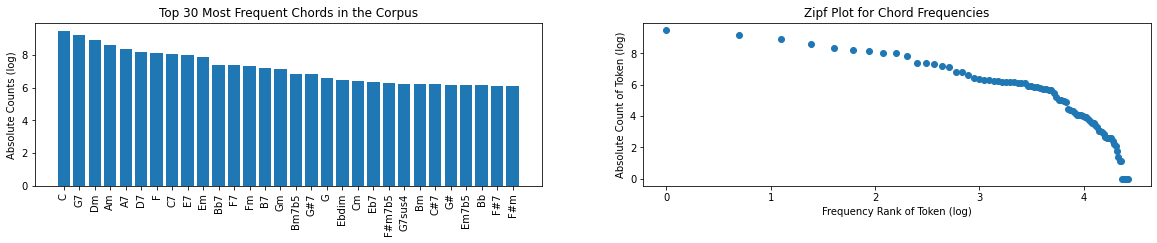

In [ ]:
plt.figure(figsize=(20, 3))

plt.subplot(1, 2, 1)

n = 30
df_top = df_chords_top.head(n)
plt.bar(df_top['chord'], np.log(df_top['count']))
plt.xlabel('')
plt.ylabel('Absolute Counts (log)')
plt.title(f'Top {n} Most Frequent Chords in the Corpus')
ax = plt.gca()
ax.set_xticklabels(labels=df_chords_top['chord'],rotation=90);

plt.subplot(1, 2, 2)

plt.scatter(np.log(frequency_rank), np.log(word_counts))
plt.xlabel('Frequency Rank of Token (log)')
plt.ylabel('Absolute Count of Token (log)')
plt.title('Zipf Plot for Chord Frequencies')

plt.savefig('plot.png')

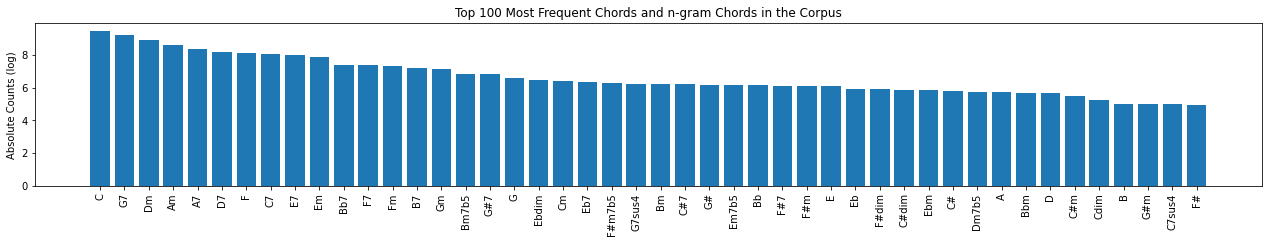

In [ ]:
plt.figure(figsize=(22, 3))

n = 100

df_top = df_chords_top.head(n)
plt.bar(df_top['chord'], np.log(df_top['count']))
plt.xlabel('')
plt.ylabel('Absolute Counts (log)')
plt.title(f'Top {n} Most Frequent Chords and n-gram Chords in the Corpus')
ax = plt.gca()
ax.set_xticklabels(labels=df_chords_top['chord'],rotation=90);

In [ ]:
if use_wandb:
  wandb.log(
      {"corpus": {
              "total_tokens": total_tokens,
              "vocab_size": vocab_size,
              "vocab_proportion_in_corpus": vocab_prop,
              "zipf_plot": wandb.Image('plot.png'),
              }
      }
  )

# TF-IDF

In [ ]:
dictionary = corpora.Dictionary(processed_corpus)
bow_corpus = [dictionary.doc2bow(text) for text in processed_corpus]
tfidf = TfidfModel(bow_corpus)

2021-12-20 13:11:43,167 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-12-20 13:11:43,449 : INFO : built Dictionary(83 unique tokens: ['Am', 'B7', 'C', 'C#', 'C7']...) from 5536 documents (total 76721 corpus positions)
2021-12-20 13:11:43,458 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(83 unique tokens: ['Am', 'B7', 'C', 'C#', 'C7']...) from 5536 documents (total 76721 corpus positions)", 'datetime': '2021-12-20T13:11:43.458245', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'created'}
2021-12-20 13:11:43,589 : INFO : collecting document frequencies
2021-12-20 13:11:43,596 : INFO : PROGRESS: processing document #0
2021-12-20 13:11:43,624 : INFO : TfidfModel lifecycle event {'msg': 'calculated IDF weights for 5536 documents and 83 features (41442 matrix non-zeros)', 'datetime': '2021-12-20T13:11:43.624003', 'gensim': '4.1.2', 'python': '3.

In [ ]:
# dictionary.token2id

In [ ]:
!rm -R index
!mkdir index

rm: cannot remove 'index': No such file or directory


In [ ]:
# Note: SparseMatrixSimilarity crashes due to lacking memory
#from gensim.test.utils import get_tmpfile
#index_tmpfile = get_tmpfile("index")
#index_tfidf = similarities.Similarity('/content/index/index_tfidf', bow_corpus, num_features=len(dictionary))

index_tfidf = similarities.SparseMatrixSimilarity(tfidf[bow_corpus], num_features = len(dictionary))

2021-12-20 13:11:44,005 : INFO : creating sparse index
2021-12-20 13:11:44,027 : INFO : creating sparse matrix from corpus
2021-12-20 13:11:44,042 : INFO : PROGRESS: at document #0
2021-12-20 13:11:45,151 : INFO : created <5536x83 sparse matrix of type '<class 'numpy.float32'>'
	with 41442 stored elements in Compressed Sparse Row format>


In [ ]:
tfidf.save('/content/index/tfidf.model')  # save model
index_tfidf.save('/content/index/tfidf.index') #save index

2021-12-20 13:11:45,174 : INFO : TfidfModel lifecycle event {'fname_or_handle': '/content/index/tfidf.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-12-20T13:11:45.174691', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'saving'}
2021-12-20 13:11:45,186 : INFO : saved /content/index/tfidf.model
2021-12-20 13:11:45,194 : INFO : SparseMatrixSimilarity lifecycle event {'fname_or_handle': '/content/index/tfidf.index', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-12-20T13:11:45.194536', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'saving'}
2021-12-20 13:11:45,201 : INFO : saved /content/index/tfidf.index


## Tests

In [ ]:
def get_sim_scores(tunes, index, model, topn=50):

    df_sim = pd.DataFrame(columns=['reference_title',
                                   'reference_titleid',
                                   'similar_title',
                                   'similar_titleid',
                                   'ref_section', 
                                   'ref_section_label',
                                   'ref_sectionid',
                                   'similar_section',
                                   'similar_section_label',
                                   'similar_sectionid',
                                   'score', 
                                  ])

    for tune in tqdm(tunes):
      for s1 in title_to_sectionid[tune]:
      
          query = processed_corpus[s1]
          query_bow = dictionary.doc2bow(query)

          # perform a similarity query against the corpus
          similarities = index[model[query_bow]]
          sims = sorted(enumerate(similarities), key=lambda item: -item[1])
          
          n = 0
          for s2, s2_score in sims:
            
            # store the top N best results
            if n > topn:
                break
            # don't count self-similarity between sections of the same tune
            if s2 not in title_to_sectionid[tune]:
                # print(f"\t{s2_score:.3f} {sectionid_to_section[s2]}")
                n += 1
                df_sim.loc[len(df_sim)] = [tune,
                                           title_to_titleid[tune],
                                           sectionid_to_title[s2],
                                           sectionid_to_titleid[s2],
                                           sectionid_to_section[s1],
                                           sectionid_to_sectionlabel[s1],
                                           s1,
                                           sectionid_to_section[s2], 
                                           sectionid_to_sectionlabel[s2],
                                           s2,
                                           s2_score, 
                                           ]
    return df_sim

In [ ]:
def recommend_tune(df, tune_name):

  threshold = 0.5 # arbitrary value, selected based on distribution of max scores

  df_tune = df.query(f'reference_title == "{tune_name}"')
  ff = df_tune.iloc[:]

  # get the maximum similarity score for each section and store in new column
  ff['max'] = ff.groupby('ref_section')['score'].transform('max')

  # consider only results for scores above threshold
  ff = ff.loc[(ff['max'] > threshold)]

  # scale the score with the maxmum value of each section
  ff['score_div_max'] = ff['score'] / ff['max']

  # for each similar title, aggregate all of its sections using the median value
  result = ff.groupby('similar_title').median().sort_values('score_div_max', ascending=False)
    
  # if multiple rows from the same similar tune, keep only the similar_title with the highest score_div_max
  result = result.groupby('similar_title').max('score_div_max').sort_values('score_div_max', ascending=False)

  # add the name of the reference tune
  result['reference'] = tune_name
  result['reference_titleid'] = title_to_titleid[tune_name]

  result = result.reset_index()
  result = result.loc[:, ['reference', 'reference_titleid', 'similar_title', 'score', 'max', 'score_div_max']]
  result['similar_titleid'] = result['similar_title'].apply(lambda x: title_to_titleid[x])
  result = result.reset_index()
  return result, ff

### Single Tunes

In [ ]:
%%time
df_sim = get_sim_scores(tunes_eval_list, index_tfidf, tfidf)

# save a copy of the results; all results will be concatenated at the end
df_tfidf = df_sim[:]

100%|██████████| 11/11 [00:29<00:00,  2.66s/it]

CPU times: user 24.4 s, sys: 328 ms, total: 24.8 s
Wall time: 29.3 s


In [ ]:
import plotly.express as px
fig = px.histogram(df_sim, x="score", nbins=50, title='Scores for TF-IDF')
fig.show()

In [ ]:
if use_wandb:
  wandb.log({"scores_hist": fig})

In [ ]:
result, details = recommend_tune(df_sim, "Blue Moon [jazz1350]")
result.head(30)

,index,reference,reference_titleid,similar_title,score,max,score_div_max,similar_titleid
0,0,Blue Moon [jazz1350],157,Home Cookin' [jazz1350],0.828956,0.828956,1.000000,465
1,1,Blue Moon [jazz1350],157,It Could Happen To You [jazz1350],0.806051,0.806051,1.000000,615
2,2,Blue Moon [jazz1350],157,"Things We Did Last Summer, The [jazz1350]",0.787050,0.806051,0.976427,1166
3,3,Blue Moon [jazz1350],157,Teach Me Tonight [jazz1350],0.784768,0.806051,0.973596,1139
4,4,Blue Moon [jazz1350],157,Nice 'n Easy [jazz1350],0.779809,0.806051,0.967443,864
5,5,Blue Moon [jazz1350],157,That Old Feeling [jazz1350],0.768108,0.806051,0.952928,1147
6,6,Blue Moon [jazz1350],157,Bye Bye Blackbird [jazz1350],0.760383,0.806051,0.943344,204
7,7,Blue Moon [jazz1350],157,Don't Be That Way [jazz1350],0.843708,0.896170,0.941460,313
8,8,Blue Moon [jazz1350],157,Sophisticated Lady [jazz1350],0.753242,0.806051,0.934485,1072
9,9,Blue Moon [jazz1350],157,Look For The Silver Lining [jazz1350],0.834405,0.896170,0.931079,733


Copy results into a dataframe for later logging to W&B

In [ ]:
dd = pd.DataFrame(columns = recommender_results_cols)

for tune in tunes_eval_list:
  result, details = recommend_tune(df_sim, tune)
  dd['id'] = result['index']
  dd['method'] = 'tfidf'
  dd['reference'] = tune
  dd['similar'] = result['similar_title']
  dd['score_div_max'] = result['score_div_max']
  dd['score'] = result['score']

recommender_results = recommender_results.append(dd)

### Test Contrafacts

With the model, query the top N highest matches for each section. For a tune, if at least one section receives the recommendation  for the expected title, increase the match counter.

In [ ]:
def test_contrafacts(tunes, index, model, N=15):
  matches = 0
  number_of_sections = 0
  results = {}

  for tune, similar_tune in tunes:

    # loop over all sections of the tune
    section_matches = 0
    for s1 in title_to_sectionid[tune]:
      query = processed_corpus[s1]
      query_bow = dictionary.doc2bow(query)

      # perform a similarity query against the corpus
      similarities = index[model[query_bow]]
      sims = sorted(enumerate(similarities), key=lambda item: -item[1])

      # check if the section matches the expected title; consider only the first 15 recommendations
      i = 0
      for sectionid, value in sims:
        if i >= N:
          break
        i += 1
        if sectionid_to_title[sectionid] == similar_tune:
          section_matches += 1

    # for each title, increase matches if at least one of the section matched the expected title
    if section_matches > 0:
      matches += 1  
      results[f'{tune}, {similar_tune}'] = 1
    else:
      results[f'{tune}, {similar_tune}'] = 0
  
  return matches, results


In [ ]:
topN = 20
matches, results = test_contrafacts(contrafacts, index_tfidf, tfidf, topN)

print(f"Found matches: {matches} out of {len(results)}: {100*matches/len(results):.3f}%")
print() 
for rr, val in results.items():
  if val == 0:
    print(f"{val}: {rr}")

Found matches: 85 out of 111: 76.577%

0: 52nd Street Theme [jazz1350], I Got Rhythm [jazz1350]
0: Ballade [jazz1350], As Long As I Live [jazz1350]
0: Dewey Square [jazz1350], Oh, Lady Be Good [jazz1350]
0: Don't Be That Way [jazz1350], I Got Rhythm [jazz1350]
0: Good Bait [jazz1350], I Got Rhythm [jazz1350]
0: In A Mellow Tone (In A Mellotone) [jazz1350], Rose Room [jazz1350]
0: Lennie's Pennies [jazz1350], Pennies From Heaven [jazz1350]
0: Little Rootie Tootie [jazz1350], I Got Rhythm [jazz1350]
0: Little Willie Leaps [jazz1350], All God's Chillun Got Rhythm [jazz1350]
0: Lullaby Of Birdland [jazz1350], Love Me Or Leave Me [jazz1350]
0: My Little Suede Shoes [jazz1350], Jeepers Creepers [jazz1350]
0: Quasimodo (Theme) [jazz1350], Embraceable You [jazz1350]
0: Room 608 [jazz1350], I Got Rhythm [jazz1350]
0: Scrapple From The Apple [jazz1350], Honeysuckle Rose [jazz1350]
0: Sweet Sue, Just You [jazz1350], Honeysuckle Rose [jazz1350]
0: Sweet Sue, Just You [jazz1350], Bye Bye Blackbird 

In [ ]:
model_name = 'tfidf'
if use_wandb:
  wandb.log(
      {model_name: {
                'contrafacts': {
                    'topN': topN,
                    'success': matches/len(contrafacts),
                    #'results': results
                    }
                   },
       'all_models': {
           model_name: wandb.Table(
               columns=["Title", "Match"],
               data=[[key, value] for key, value in results.items()]),
       }
       })

## Store TF-IDF Model to W&B

In [ ]:
if use_wandb:
  model_artifact = wandb.Artifact(
      "model_tfidf", 
      type="model",
      description="TF-IDF Model",
      metadata="")

  model_artifact.add_file("/content/index/tfidf.model")
  model_artifact.add_file("/content/index/tfidf.index")
  wandb.log_artifact(model_artifact)

## Get Recommender Data for WebApp



In [ ]:
tune_test = ["These Foolish Things [jazz1350]",
             "Misty [jazz1350]"]

In [ ]:
%%time
if True:
  #_tunes = list(tunes['title_playlist'].values())
  _tunes = tunes_eval_list

  method = 'tfidf'

  df_sim = get_sim_scores(_tunes, index_tfidf, tfidf, topn=50)

  # save to file
  (df_sim
   .loc[:,['reference_title',
           'reference_titleid',
           'similar_title',
           'similar_titleid',
           'ref_section_label',
           'similar_section_label',
           'score'
           ]]
   .reset_index()
   .groupby(['reference_titleid', 'reference_title', 
             'similar_titleid','similar_title', 
             'ref_section_label', 'similar_section_label'])
   .max('score')
   .sort_values('score', ascending=False)
   .reset_index()
   .to_csv(f'output/recommender_{method}.csv', encoding='utf8')
  )

  with zipfile.ZipFile(f'output/recommender_{method}.zip', 'w') as zf:
    zf.write(f'output/recommender_{method}.csv')

  # save to wandb
  if use_wandb:
    model_artifact = wandb.Artifact(
        f"recommender_{method}", 
        type="csv",
        description=f"Recommendations for each Tune using {method} Model (csv file)",
        metadata="")

    model_artifact.add_file(f'output/recommender_{method}.zip')
    wandb.log_artifact(model_artifact)

100%|██████████| 11/11 [00:18<00:00,  1.69s/it]

CPU times: user 18.8 s, sys: 593 ms, total: 19.4 s
Wall time: 18.7 s


# LSA (Latent Semantic Analysis), aka LSI (Latent Semantic Index) 

In [ ]:
from collections import defaultdict

In [ ]:
num_topics = lsi_config['num_topics']

# remove words that appear only once
frequency = defaultdict(int)
for text in processed_corpus:
    for token in text:
        frequency[token] += 1

data = [[token for token in text if frequency[token] > 1] for text in processed_corpus]
dictionary = corpora.Dictionary(data)

# doc2bow counts the number of occurences of each distinct word,
# converts the word to its integer word id and returns the result
# as a sparse vector

bow_corpus = [dictionary.doc2bow(text) for text in data]
lsi = LsiModel(bow_corpus, id2word=dictionary, num_topics=num_topics)  # num_topics can be maximum the size of the number of unique tokens

2021-12-20 13:12:36,950 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-12-20 13:12:37,067 : INFO : built Dictionary(78 unique tokens: ['Am', 'B7', 'C', 'C#', 'C7']...) from 5536 documents (total 76716 corpus positions)
2021-12-20 13:12:37,069 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(78 unique tokens: ['Am', 'B7', 'C', 'C#', 'C7']...) from 5536 documents (total 76716 corpus positions)", 'datetime': '2021-12-20T13:12:37.069086', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'created'}
2021-12-20 13:12:37,133 : INFO : using serial LSI version on this node
2021-12-20 13:12:37,135 : INFO : updating model with new documents
2021-12-20 13:12:37,138 : INFO : preparing a new chunk of documents
2021-12-20 13:12:37,171 : INFO : using 100 extra samples and 2 power iterations
2021-12-20 13:12:37,172 : INFO : 1st phase: constructing (78, 200) action

In [ ]:
index_lsi = similarities.Similarity('/content/index/index_lsi', lsi[bow_corpus], num_features=len(dictionary))

2021-12-20 13:12:37,454 : INFO : starting similarity index under /content/index/index_lsi


In [ ]:
#index_lsi = similarities.SparseMatrixSimilarity(lsi[bow_corpus], num_features = len(dictionary))
#index_lsi = similarities.MatrixSimilarity(lsi[bow_corpus])  # transform corpus to LSI space and index it


In [ ]:
lsi.save('/content/index/lsi.model')
index_lsi.save('/content/index/lsi_matrixsim.index')


2021-12-20 13:12:38,332 : INFO : Projection lifecycle event {'fname_or_handle': '/content/index/lsi.model.projection', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-12-20T13:12:38.331992', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'saving'}
2021-12-20 13:12:38,335 : INFO : saved /content/index/lsi.model.projection
2021-12-20 13:12:38,338 : INFO : LsiModel lifecycle event {'fname_or_handle': '/content/index/lsi.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': ['projection', 'dispatcher'], 'datetime': '2021-12-20T13:12:38.338405', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'saving'}
2021-12-20 13:12:38,341 : INFO : not storing attribute projection
2021-12-20 13:12:38,343 : INFO : not storing attribute dispatch

In [ ]:
!ls -la /content/index

total 2108
drwxr-xr-x 2 root root    4096 Dec 20 13:12 .
drwxr-xr-x 1 root root    4096 Dec 20 13:11 ..
-rw-r--r-- 1 root root 1727904 Dec 20 13:12 index_lsi.0
-rw-r--r-- 1 root root     742 Dec 20 13:12 lsi_matrixsim.index
-rw-r--r-- 1 root root    2844 Dec 20 13:12 lsi.model
-rw-r--r-- 1 root root   49976 Dec 20 13:12 lsi.model.projection
-rw-r--r-- 1 root root  354572 Dec 20 13:11 tfidf.index
-rw-r--r-- 1 root root    3057 Dec 20 13:11 tfidf.model


## Tests

### Test for single tunes

In [ ]:
%%time
df_sim = get_sim_scores(tunes_eval_list, index=index_lsi, model=lsi)

# save a copy of the results; all results will be concatenated at the end
df_lsi = df_sim[:]

100%|██████████| 11/11 [00:19<00:00,  1.77s/it]

CPU times: user 19.8 s, sys: 4.53 s, total: 24.4 s
Wall time: 19.5 s


In [ ]:
import plotly.express as px
fig = px.histogram(df_sim, x="score", nbins=50, title='LSI Scores')
fig.show()

In [ ]:
title_to_titleid['Take The A Train [jazz1350]']

1134

In [ ]:
title_to_sectionid['Take The A Train [jazz1350]']

[3802, 3803, 3804, 3805]

In [ ]:
sectionid_to_section[3764]

'Surrey With The Fringe On The Top, section5 (C)'

In [ ]:
sectionid_to_sectionlabel[3764]

'C'

In [ ]:
foolish = (df_sim[df_sim['reference_titleid'] == 1140]
           .reset_index()
           .drop(columns=['reference_titleid',
                          'ref_section', 
                          'ref_sectionid',
                          'similar_titleid', 
                          'similar_section',
                          'similar_sectionid', 
                          'index'])
           .groupby(['reference_title', 'similar_title', 'ref_section_label', 'similar_section_label'])
           .max('score')
           .sort_values('score', ascending=False)
           .reset_index()
)

foolish

,reference_title,similar_title,ref_section_label,similar_section_label,score


In [ ]:
if use_wandb:
  wandb.log({"scores_hist": fig})

In [ ]:
result, details = recommend_tune(df_sim, 'These Foolish Things [jazz1350]')
result.head(30)

,index,reference,reference_titleid,similar_title,score,max,score_div_max,similar_titleid
0,0,These Foolish Things [jazz1350],1159,More Than You Know [jazz1350],0.916515,0.916515,1.000000,822
1,1,These Foolish Things [jazz1350],1159,"Way You Look Tonight, The [jazz1350]",0.942543,0.954669,0.994969,1244
2,2,These Foolish Things [jazz1350],1159,"Party's Over, The [jazz1350]",0.922840,0.954669,0.991636,928
3,3,These Foolish Things [jazz1350],1159,It's Easy To Remember [jazz1350],0.951817,0.954669,0.984507,631
4,4,These Foolish Things [jazz1350],1159,Look To The Rainbow [jazz1350],0.895809,0.911765,0.982500,735
5,5,These Foolish Things [jazz1350],1159,I've Got You Under My Skin [jazz1350],0.895171,0.911765,0.981801,562
6,6,These Foolish Things [jazz1350],1159,Mean To Me [jazz1350],0.893260,0.911765,0.979704,776
7,7,These Foolish Things [jazz1350],1159,And The Angels Sing [jazz1350],0.920751,0.954669,0.979704,78
8,8,These Foolish Things [jazz1350],1159,They All Laughed [jazz1350],0.928085,0.954669,0.979704,1160
9,9,These Foolish Things [jazz1350],1159,'Tain't No Sin To Take Off Your Skin [trad],0.893089,0.911765,0.979517,1330


In [ ]:
dd = pd.DataFrame(columns = recommender_results_cols)

for tune in tunes_eval_list:
  result, details = recommend_tune(df_sim, tune)
  dd['id'] = result['index']
  dd['reference'] = tune
  dd['method'] = 'lsi'
  dd['similar'] = result['similar_title']
  dd['score_div_max'] = result['score_div_max']
  dd['score'] = result['score']

recommender_results = recommender_results.append(dd)

### Tests for Contrafacts

In [ ]:
len(results)

111

In [ ]:
len(contrafacts)

111

In [ ]:
contrafacts

[('26-2 [jazz1350]', 'Confirmation [jazz1350]'),
 ('52nd Street Theme [jazz1350]', 'I Got Rhythm [jazz1350]'),
 ('Ablution [jazz1350]', 'All The Things You Are [jazz1350]'),
 ('Anthropology [jazz1350]', 'I Got Rhythm [jazz1350]'),
 ('Ballade [jazz1350]', 'As Long As I Live [jazz1350]'),
 ('Bright Mississippi [jazz1350]', 'Sweet Georgia Brown [jazz1350]'),
 ('C.T.A. [jazz1350]', 'I Got Rhythm [jazz1350]'),
 ('Cottontail [jazz1350]', 'I Got Rhythm [jazz1350]'),
 ('Countdown [jazz1350]', 'Tune Up [jazz1350]'),
 ('Dewey Square [jazz1350]', 'Oh, Lady Be Good [jazz1350]'),
 ('Dexterity [jazz1350]', 'I Got Rhythm [jazz1350]'),
 ('Dig [jazz1350]', 'Sweet Georgia Brown [jazz1350]'),
 ('Donna Lee [jazz1350]', 'Indiana (Back Home Again In) [jazz1350]'),
 ("Don't Be That Way [jazz1350]", 'I Got Rhythm [jazz1350]'),
 ('Evidence [jazz1350]', 'Just You, Just Me [jazz1350]'),
 ('Flintstones [jazz1350]', 'I Got Rhythm [jazz1350]'),
 ('Four On Six [jazz1350]', 'Summertime [jazz1350]'),
 ('Freight Train 

In [ ]:
results

{'26-2 [jazz1350], Confirmation [jazz1350]': 1,
 '52nd Street Theme [jazz1350], I Got Rhythm [jazz1350]': 0,
 'A Blossom Fell [jazz1350], Among My Souvenirs [jazz1350]': 1,
 'A Night In Tunisia [jazz1350], Segment [jazz1350]': 1,
 'Ablution [jazz1350], All The Things You Are [jazz1350]': 1,
 'All I Do Is Dream Of You [trad], L-O-V-E [jazz1350]': 1,
 'Alone Together [jazz1350], A Night In Tunisia [jazz1350]': 1,
 'Alone Together [jazz1350], Segment [jazz1350]': 1,
 'Am I Blue [jazz1350], Come Back To Me [jazz1350]': 1,
 'Anthropology [jazz1350], I Got Rhythm [jazz1350]': 1,
 "As Long As I Live [jazz1350], I'm Glad There Is You [jazz1350]": 1,
 'Ballade [jazz1350], As Long As I Live [jazz1350]': 0,
 'Baubles, Bangles and Beads [jazz1350], Bossa Antigua [jazz1350]': 1,
 'Bei Mir Bist Du Schon (Root Hog Or Die) [trad], Egyptian Fantasy [trad]': 1,
 "Bei Mir Bist Du Schon (Root Hog Or Die) [trad], Puttin' On The Ritz [jazz1350]": 1,
 'Bill Bailey [jazz1350], Bourbon Street Parade [jazz1350]

In [ ]:
topN = 20
matches, results = test_contrafacts(contrafacts, index_lsi, lsi, topN)

print(f"Found matches: {matches} out of {len(results)}: {100*matches/len(results):.3f}%")
print() 
for rr, val in results.items():
  if val == 0:
    print(f"{val}: {rr}")


Found matches: 91 out of 111: 81.982%

0: 52nd Street Theme [jazz1350], I Got Rhythm [jazz1350]
0: Ballade [jazz1350], As Long As I Live [jazz1350]
0: Dewey Square [jazz1350], Oh, Lady Be Good [jazz1350]
0: Good Bait [jazz1350], I Got Rhythm [jazz1350]
0: Lennie's Pennies [jazz1350], Pennies From Heaven [jazz1350]
0: Little Rootie Tootie [jazz1350], I Got Rhythm [jazz1350]
0: Little Willie Leaps [jazz1350], All God's Chillun Got Rhythm [jazz1350]
0: My Little Suede Shoes [jazz1350], Jeepers Creepers [jazz1350]
0: Quasimodo (Theme) [jazz1350], Embraceable You [jazz1350]
0: Room 608 [jazz1350], I Got Rhythm [jazz1350]
0: Wow [jazz1350], You Can Depend On Me [jazz1350]
0: Sweet Sue, Just You [jazz1350], Honeysuckle Rose [jazz1350]
0: Sweet Sue, Just You [jazz1350], Bye Bye Blackbird [jazz1350]
0: These Foolish Things [jazz1350], Blue Moon [jazz1350]
0: These Foolish Things [jazz1350], Soultrane [jazz1350]
0: These Foolish Things [jazz1350], Why Do I Love You [jazz1350]
0: Exactly Like You

In [ ]:
model_name = 'lsi'
if use_wandb:
  wandb.log(
      {model_name: {
                'contrafacts': {
                    'topN': topN,
                    'success': matches/len(contrafacts),
                    #'results': results
                    }
                   },
       'all_models': {
           model_name: wandb.Table(
               columns=["Title", "Match"],
               data=[[key, value] for key, value in results.items()]),
       }
       })

### Get Recommender Data for WebApp

In [ ]:
result.columns

Index(['index', 'reference', 'reference_titleid', 'similar_title', 'score', 'max', 'score_div_max', 'similar_titleid'], dtype='object')

In [ ]:
%%time
if generate_webapp_data:
  _tunes = list(tunes['title_playlist'].values())
  #_tunes = tunes_eval_list

  method = 'lsi'

  # save the mapping between titleid and title to disk
  pd.DataFrame.from_dict(tunes).to_csv(f'output/index_{method}.csv', index_label='titleid')
  with zipfile.ZipFile(f'output/index_{method}.zip', 'w') as zf:
    zf.write(f'output/index_{method}.csv')

  df_sim = get_sim_scores(_tunes, index_lsi, lsi, topn=30)

  # save to file
  (df_sim
   .loc[:,[#'reference_title',
           'reference_titleid',
           #'similar_title',
           'similar_titleid',
           'ref_section_label',
           'similar_section_label',
           'score'
           ]]
   .groupby(['reference_titleid', 
          #'reference_title', 
          'similar_titleid',
          #'similar_title', 
          'ref_section_label', 
          'similar_section_label'])
   .max('score')
   .reset_index()
   .to_csv(f'output/recommender_{method}.csv', encoding='utf8', index=False)
  )
  
  with zipfile.ZipFile(f'output/recommender_{method}.zip', 'w') as zf:
    zf.write(f'output/recommender_{method}.csv')

  # save to wandb
  if use_wandb:
    model_artifact = wandb.Artifact(
        f"recommender_{method}", 
        type="csv",
        description=f"Recommendations for each Tune using {method} Model (csv file)",
        metadata="")

    model_artifact.add_file(f'output/recommender_{method}.zip')
    model_artifact.add_file(f'output/index_{method}.zip')
    wandb.log_artifact(model_artifact)

100%|██████████| 1686/1686 [1:50:15<00:00,  3.92s/it]


CPU times: user 1h 49min 12s, sys: 11min 43s, total: 2h 56s
Wall time: 1h 50min 16s


## Store Model to W&B

In [ ]:
if use_wandb:
  model_artifact = wandb.Artifact(
      "model_lsi", 
      type="model",
      description="LSI model",
      metadata="")

  model_artifact.add_file("/content/index/lsi.model")
  model_artifact.add_file("/content/index/lsi_matrixsim.index")
  model_artifact.add_file("/content/index/lsi.model.projection")
  wandb.log_artifact(model_artifact)

## Determine Number of Topics for LSI Model

This sample comes from Datacamp: 

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python


What is the best way to determine k (number of topics) in topic modeling? Identify the optimum number of topics in the given corpus text is a challenging task. We can use the following options for determining the optimum number of topics:

* One way to determine the optimum number of topics is to consider each topic as a cluster and find out the effectiveness of a cluster using the Silhouette coefficient.
* Topic coherence measure is a realistic measure for identifying the number of topics.

Topic Coherence measure is a widely used metric to evaluate topic models. It uses the latent variable models. Each generated topic has a list of words. In topic coherence measure, you will find average/median of pairwise word similarity scores of the words in a topic. The high value of topic coherence score model will be considered as a good topic model. 

In [ ]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary, doc_term_matrix

In [ ]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [ ]:
def plot_graph(doc_clean,start, stop, step):
    dictionary, doc_term_matrix = prepare_corpus(doc_clean)

    runs = 5
    for i in range(runs):
      model_list, coherence_values = compute_coherence_values(dictionary, 
                                                              doc_term_matrix,
                                                              doc_clean,
                                                              stop, start, step)
      # Show graph
      x = range(start, stop, step)
      plt.plot(x, coherence_values, color='blue')

    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.show()

In [ ]:
# evaluate a good number of topics for the LSI Model. This takes some time.

if False:

  start, stop, step = 2, 50, 2
  plot_graph(data, start, stop, step)

For unigrams, the best number of topics that is most consistently for the 5 runs seems to be around 22.

For unigrams plus bigrams, the coherence score drops down until 100 and then continuously rises until 500 and continues to rise. Same for bigrams-only.

# Doc2Vec

In [ ]:
def get_tagged_documents(corpus, tag_sections_and_tunes=False):
  if tag_sections_and_tunes:
    print('Tagging input data with both section and tune information.')
  else:
    print('Tagging input data with section informaiton only.')
    
  for i, tokens in enumerate(corpus):
    if tag_sections_and_tunes:
      yield gensim.models.doc2vec.TaggedDocument(tokens, [i, f'titleid_{sectionid_to_titleid[i]}'])
    else:
      yield gensim.models.doc2vec.TaggedDocument(tokens, [i])  # diatonic chord distance is a bit better

In [ ]:
train_corpus = list(get_tagged_documents(processed_corpus, doc2vec_config['general']['tag_sections_and_tunes']))
train_corpus[1000]

Tagging input data with section informaiton only.


TaggedDocument(words=['Am', 'Bm7b5', 'E7', 'Am', 'Dm', 'G7', 'C7', 'B7', 'Bb7', 'A7', 'D7', 'G7', 'C'], tags=[1000])

In [ ]:
import multiprocessing

print(f"CPU Count: {multiprocessing.cpu_count()}")
print(f"Config:")
print(doc2vec_config['model'])

model = Doc2Vec(train_corpus,
                **doc2vec_config['model']
                )

2021-12-20 15:03:19,165 : INFO : collecting all words and their counts
2021-12-20 15:03:19,168 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2021-12-20 15:03:19,203 : INFO : collected 83 word types and 5536 unique tags from a corpus of 5536 examples and 76721 words
2021-12-20 15:03:19,206 : INFO : Creating a fresh vocabulary
2021-12-20 15:03:19,208 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 retains 83 unique words (100.0%% of original 83, drops 0)', 'datetime': '2021-12-20T15:03:19.208891', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'prepare_vocab'}
2021-12-20 15:03:19,212 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 76721 word corpus (100.0%% of original 76721, drops 0)', 'datetime': '2021-12-20T15:03:19.212117', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.

CPU Count: 2
Config:
{'dm': 1, 'vector_size': 100, 'window': 2, 'epochs': 40, 'min_count': 1, 'negative': 10, 'sample': 0.001, 'seed': 42}


2021-12-20 15:03:20,088 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-12-20 15:03:20,203 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-12-20 15:03:20,210 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-12-20 15:03:20,214 : INFO : EPOCH - 1 : training on 76721 raw words (23231 effective words) took 0.9s, 24841 effective words/s
2021-12-20 15:03:21,077 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-12-20 15:03:21,169 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-12-20 15:03:21,197 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-12-20 15:03:21,198 : INFO : EPOCH - 2 : training on 76721 raw words (23288 effective words) took 1.0s, 23917 effective words/s
2021-12-20 15:03:21,992 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-12-20 15:03:22,126 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-12-

In [ ]:
if use_wandb:
  model_artifact = wandb.Artifact(
      "model_doc2vec", 
      type="model",
      description="Doc2Vec model",
      metadata="")

  fname = 'doc2vec.model'
  model.save(fname)

  model_artifact.add_file(fname)
  wandb.log_artifact(model_artifact)

2021-12-20 15:03:55,281 : INFO : Doc2Vec lifecycle event {'fname_or_handle': 'doc2vec.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-12-20T15:03:55.281238', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'saving'}
2021-12-20 15:03:55,284 : INFO : not storing attribute cum_table
2021-12-20 15:03:55,294 : INFO : saved doc2vec.model


### Test the distance between C and the diatonic chords

Test if the model can capture that the diatonic chords are closer to the root.

Do this only if the input corpus contains the unigrams. 

In [ ]:
test_tokens = ['C',
              'Dm',
              'Em',
              'F',
              'G7',
              'Am',
              #'Bm7b5',
              'F7',
              'D7',
              'A7',
              'E7',
              'B7',
              'F#7',
               'Cm',
               'D']

if 1 in ngrams_for_input:
  ref = 'C'
  for t in test_tokens:
    print(f"{model.wv.similarity(ref, t):.3f}: {ref} <-> {t}")

In [ ]:
if 1 in ngrams_for_input:
  print(model.wv.similar_by_word('C', topn=20))

In [ ]:
if 1 in ngrams_for_input:
  # 20 closest chords to 'C'
  vectors = []
  chord_names = []
  similar_chords = model.wv.similar_by_word('C', topn=10)
  for c in similar_chords:
    vectors.append(model.wv.get_vector(c[0]))
    chord_names.append(c[0])

  weights = np.array(vectors)


Plot the generated word vectors in 2D space

In [ ]:
from sklearn.manifold import TSNE

# input data: vectors for all tokens
weights = model.wv.vectors

# only do this when the vocabulary is not too big....
if len(weights) < 100:

  # do T-SNE
  tsne = TSNE(n_components=2, 
              random_state=42,
              perplexity=30,
              learning_rate='auto',
              init='pca',
              n_iter=2000
              )
  T = tsne.fit_transform(weights)

  # plot
  projected = pd.DataFrame(T)

  fig = px.scatter(
      projected, 
      x=0, y=1,
      #color='mode',
      text=model.wv.index_to_key,
      width=800, height=600,
      title="T-SNE applied to Chord Vectors for Tunes in Cmaj/Amin"
  )
  fig.update_traces(textposition='top center')
  fig.update_traces(textfont_size=12, selector=dict(type='scatter'))
  fig.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



## Section Similarity


### Single Tunes

In [ ]:
def get_section_scores_doc2vec(tunes):

  df_sim = pd.DataFrame(columns=['reference_title',
                                  'reference_titleid',
                                  'similar_title',
                                  'similar_titleid',
                                  'ref_section', 
                                  'ref_section_label',
                                  'ref_sectionid',
                                  'similar_section',
                                  'similar_section_label',
                                  'similar_sectionid',
                                  'score', 
                                ])

  tag_sections_and_tunes = doc2vec_config['general']['tag_sections_and_tunes']

  ### get titleid from tunes, use enumerate

  for tune in tunes:
    print()
    print("-"*50)
    for s1 in title_to_sectionid[tune]:
    
      # sections are tagged with the numeric sectionid and can be used for querying
      sims = model.dv.similar_by_key(s1, topn=20)
      
      print(s1, sectionid_to_section[s1])
      n = 0
      for s2, s2_score in sims:

        # if the sections are tagged with both sectionid and tuneid:
        if tag_sections_and_tunes:
          # only consider similarities to tuneids, ignore sectionids
          if type(s2) == str: 
            s2 = int(s2.replace('titleid_', ''))
            # don't count self-similarity between sections of the same tune
            if s2 not in title_to_sectionid[tune]:
              n += 1
          
              # print(f"\t{s2_score:.3f} {sectionid_to_section[s2]}")

              df_sim.loc[len(df_sim)] = [tune,
                                          title_to_titleid[tune],
                                          sectionid_to_title[s2],
                                          sectionid_to_titleid[s2],
                                          sectionid_to_section[s1],
                                          sectionid_to_sectionlabel[s1],
                                          s1,
                                          sectionid_to_section[s2], 
                                          sectionid_to_sectionlabel[s2],
                                          s2,
                                          s2_score, 
                                          ]
        else:
          if type(s2) == int: 
            # don't count self-similarity between sections of the same tune
            if s2 not in title_to_sectionid[tune]:
              n += 1
          
              # print(f"\t{s2_score:.3f} {sectionid_to_section[s2]}")

              df_sim.loc[len(df_sim)] = [tune,
                                          title_to_titleid[tune],
                                          sectionid_to_title[s2],
                                          sectionid_to_titleid[s2],
                                          sectionid_to_section[s1],
                                          sectionid_to_sectionlabel[s1],
                                          s1,
                                          sectionid_to_section[s2], 
                                          sectionid_to_sectionlabel[s2],
                                          s2,
                                          s2_score,  
                                          ]            

  print()
  if tag_sections_and_tunes:
    print(f"Sections are tagged with the tune id, therefore only the tune similarity is evaluated.")
  else:
    print(f"Sections are tagged only with the section id, therefore only section similarity is evaluated.")

  return df_sim

In [ ]:
_tunes = tunes_eval_list

df_sim = get_section_scores_doc2vec(_tunes)

result = None
for tune in _tunes:
  tune_result, details = recommend_tune(df_sim, tune)
  if result is None:
    result = pd.DataFrame(columns=tune_result.columns)
  result = result.append(tune_result)

print(f"Result has {len(result)} rows.")

# save a copy of the results; all results will be concatenated at the end
df_doc2vec = df_sim[:]


--------------------------------------------------
499 Blue Moon, section1 (A)
500 Blue Moon, section2 (A)
501 Blue Moon, section3 (B)
502 Blue Moon, section4 (A)

--------------------------------------------------
1226 Exactly Like You, section1 (A)
1227 Exactly Like You, section2 (A)
1228 Exactly Like You, section3 (B)
1229 Exactly Like You, section4 (A)

--------------------------------------------------
1550 Honeysuckle Rose, section1 (A)
1551 Honeysuckle Rose, section2 (A)
1552 Honeysuckle Rose, section3 (B)
1553 Honeysuckle Rose, section4 (A)

--------------------------------------------------
1664 I Got Rhythm, section1 (A)
1665 I Got Rhythm, section2 (A)
1666 I Got Rhythm, section3 (B)
1667 I Got Rhythm, section4 (A)

--------------------------------------------------
2697 Misty, section1 (A)
2698 Misty, section2 (A)
2699 Misty, section3 (B)
2700 Misty, section4 (A)

--------------------------------------------------
5160 Old Fashioned Love, section1 (A)
5161 Old Fashioned Lov

In [ ]:
import plotly.express as px
fig = px.histogram(df_sim, x="score", nbins=50, title='doc2vec sections')
fig.show()

In [ ]:
if use_wandb:
  wandb.log({"scores_hist": fig})

In [ ]:
result, details = recommend_tune(df_sim, 'On The Sunny Side Of The Street [jazz1350]')
result.head(10)

,index,reference,reference_titleid,similar_title,score,max,score_div_max,similar_titleid
0,0,On The Sunny Side Of The Street [jazz1350],899,Só Danço Samba [jazz1350],0.965924,0.965924,1.000000,1132
1,1,On The Sunny Side Of The Street [jazz1350],899,Taking A Chance On Love [jazz1350],0.945040,0.952073,0.990752,1135
2,2,On The Sunny Side Of The Street [jazz1350],899,Young And Foolish [jazz1350],0.955746,0.956335,0.990510,1324
3,3,On The Sunny Side Of The Street [jazz1350],899,After You [jazz1350],0.950771,0.964903,0.985355,39
4,4,On The Sunny Side Of The Street [jazz1350],899,Shine [jazz1350],0.934841,0.956335,0.977525,1027
5,5,On The Sunny Side Of The Street [jazz1350],899,It's A Blue World [jazz1350],0.943994,0.965924,0.977297,623
6,6,On The Sunny Side Of The Street [jazz1350],899,Save Your Sorrows For Tomorrow [trad],0.938239,0.960619,0.976785,1591
7,7,On The Sunny Side Of The Street [jazz1350],899,Minor Strain [jazz1350],0.943492,0.965924,0.976777,794
8,8,On The Sunny Side Of The Street [jazz1350],899,Eclypso [jazz1350],0.941777,0.965924,0.975001,341
9,9,On The Sunny Side Of The Street [jazz1350],899,Undecided [jazz1350],0.941698,0.965924,0.974920,1217


In [ ]:
dd = pd.DataFrame(columns = recommender_results_cols)

for tune in tunes_eval_list:
  result, details = recommend_tune(df_sim, tune)
  dd['id'] = result['index']
  dd['reference'] = tune
  dd['method'] = 'doc2vec'
  dd['similar'] = result['similar_title']
  dd['score_div_max'] = result['score_div_max']
  dd['score'] = result['score']

recommender_results = recommender_results.append(dd)
len(recommender_results)

246

### Contrafacts

In [ ]:
def test_doc2vec_contrafacts(tunes, N=15):
  """
  Evaluates if the expected tune matches by either a tune similarity or section similarity match.
  """

  matches = 0
  number_of_sections = 0
  results = {}

  for tune, similar_tune in contrafacts:
    
    # loop over all sections of the tune
    sub_match = 0
    for s1 in title_to_sectionid[tune]:
      sims = model.dv.similar_by_key(s1, topn=N)
      # check if the section matches the expected title; consider only the first N recommendations
      i = 0
      for match, value in sims:
        # tune match
        if (type(match) == str):
          titleid = int(match.replace('titleid_', ''))
          if titleid_to_title[titleid] == similar_tune:
            sub_match += 1

        # section match
        else:
          if sectionid_to_title[match] == similar_tune:
            sub_match += 1

    # for each title, increase matches if at least one of the section matched the expected title
    if sub_match > 0:
      matches += 1  
      results[f'{tune}, {similar_tune}'] = 1
    else:
      results[f'{tune}, {similar_tune}'] = 0
  
  return matches, results

In [ ]:
topN = 20
matches, results = test_doc2vec_contrafacts(contrafacts, topN)
 
print(f"Found matches: {matches} out of {len(results)}: {100*matches/len(results):.3f}%")
print() 
for rr, val in results.items():
  if val == 0:
    print(f"{val}: {rr}")


Found matches: 80 out of 111: 72.072%

0: 52nd Street Theme [jazz1350], I Got Rhythm [jazz1350]
0: Anthropology [jazz1350], I Got Rhythm [jazz1350]
0: Ballade [jazz1350], As Long As I Live [jazz1350]
0: C.T.A. [jazz1350], I Got Rhythm [jazz1350]
0: Dewey Square [jazz1350], Oh, Lady Be Good [jazz1350]
0: Dexterity [jazz1350], I Got Rhythm [jazz1350]
0: Don't Be That Way [jazz1350], I Got Rhythm [jazz1350]
0: Flintstones [jazz1350], I Got Rhythm [jazz1350]
0: Four On Six [jazz1350], Summertime [jazz1350]
0: Freight Train [jazz1350], Blues For Alice [jazz1350]
0: Good Bait [jazz1350], I Got Rhythm [jazz1350]
0: Lennie's Pennies [jazz1350], Pennies From Heaven [jazz1350]
0: Little Rootie Tootie [jazz1350], I Got Rhythm [jazz1350]
0: Little Willie Leaps [jazz1350], All God's Chillun Got Rhythm [jazz1350]
0: My Little Suede Shoes [jazz1350], Jeepers Creepers [jazz1350]
0: Quasimodo (Theme) [jazz1350], Embraceable You [jazz1350]
0: Room 608 [jazz1350], I Got Rhythm [jazz1350]
0: Scrapple From

In [ ]:
model_name = 'doc2vec'
if use_wandb:
  wandb.log(
      {model_name: {
                'contrafacts': {
                    'topN': topN,
                    'success': matches/len(contrafacts),
                    #'results': results
                    }
                   },
       'all_models': {
           model_name: wandb.Table(
               columns=["Title", "Match"],
               data=[[key, value] for key, value in results.items()]),
       }
       })

### Save Results for WebApp

In [ ]:
%%time
if False:
  #_tunes = list(tunes['title_playlist'].values())
  _tunes = tunes_eval_list

  method = 'doc2vec'

  df_sim = get_section_scores_doc2vec(_tunes)

  # save to file
  (df_sim
   .loc[:,['reference_title',
           'reference_titleid',
           'similar_title',
           'similar_titleid',
           'ref_section_label',
           'similar_section_label',
           'score'
           ]]
   .reset_index()
   .groupby(['reference_titleid', 'reference_title', 
             'similar_titleid','similar_title', 
             'ref_section_label', 'similar_section_label'])
   .max('score')
   .sort_values('score', ascending=False)
   .reset_index()
   .to_csv(f'output/recommender_{method}.csv', encoding='utf8')
  )

  with zipfile.ZipFile(f'output/recommender_{method}.zip', 'w') as zf:
    zf.write(f'output/recommender_{method}.csv')

  # save to wandb
  if use_wandb:
    model_artifact = wandb.Artifact(
        f"recommender_{method}", 
        type="csv",
        description=f"Recommendations for each Tune using {method} Model (csv file)",
        metadata="")

    model_artifact.add_file(f'output/recommender_{method}.zip')
    wandb.log_artifact(model_artifact)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


In [ ]:
%%time
if True:
  #_tunes = list(tunes['title_playlist'].values())
  _tunes = tunes_eval_list

  method = 'doc2vec'

  df_sim = get_section_scores_doc2vec(_tunes)

  result = None
  for tune in _tunes:
    tune_result, details = recommend_tune(df_sim, tune)
    if result is None:
      result = pd.DataFrame(columns=tune_result.columns)
    result = result.append(tune_result)

  # save to file
  (result
   .loc[:,['reference_titleid',
           'similar_titleid',
           'score']]
   .to_csv(f'output/recommender_{method}.csv', encoding='utf8')
  )
  with zipfile.ZipFile(f'output/recommender_{method}.zip', 'w') as zf:
    zf.write(f'output/recommender_{method}.csv')


  # save to wandb
  if use_wandb:
    model_artifact = wandb.Artifact(
        f"recommender_{method}", 
        type="csv",
        description=f"Recommendations for each Tune using {method} Model (csv file)",
        metadata="")

    model_artifact.add_file(f'output/recommender_{method}.zip')
    wandb.log_artifact(model_artifact)


--------------------------------------------------
499 Blue Moon, section1 (A)
500 Blue Moon, section2 (A)
501 Blue Moon, section3 (B)
502 Blue Moon, section4 (A)

--------------------------------------------------
1226 Exactly Like You, section1 (A)
1227 Exactly Like You, section2 (A)
1228 Exactly Like You, section3 (B)
1229 Exactly Like You, section4 (A)

--------------------------------------------------
1550 Honeysuckle Rose, section1 (A)
1551 Honeysuckle Rose, section2 (A)
1552 Honeysuckle Rose, section3 (B)
1553 Honeysuckle Rose, section4 (A)

--------------------------------------------------
1664 I Got Rhythm, section1 (A)
1665 I Got Rhythm, section2 (A)
1666 I Got Rhythm, section3 (B)
1667 I Got Rhythm, section4 (A)

--------------------------------------------------
2697 Misty, section1 (A)
2698 Misty, section2 (A)
2699 Misty, section3 (B)
2700 Misty, section4 (A)

--------------------------------------------------
5160 Old Fashioned Love, section1 (A)
5161 Old Fashioned Lov

# Venn diagrams for Results

In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

if False:
  for tune in tunes_eval_list:
    df, details = recommend_tune(df_tfidf, tune)
    tfidf_tunes = list(df.head(30).loc[:,'similar_title'])

    df, details = recommend_tune(df_lsi, tune)
    lsi_tunes = list(df.head(30).loc[:,'similar_title'])

    df, details = recommend_tune(df_doc2vec, tune)
    word2vec_tunes = list(df.head(30).loc[:,'similar_title'])

    set_tfidf = set(tfidf_tunes)
    set_lsi = set(lsi_tunes)
    set_word2vec = set(word2vec_tunes)

    venn3([set_tfidf, set_lsi, set_word2vec], 
          set_labels=('TF-IDF', 'LSI', 'Doc2Vec'),
          )
    plt.title(f"{tune}")
    plt.savefig('plot.png')
    
    if use_wandb:
      wandb.log({"venn_methods": wandb.Image('plot.png')})
    
    plt.show()

# W&B Logging and Finish

In [ ]:
if use_wandb:
  wandb.finish()